In [2]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
#Pkg.add("OptimizationOptimJL")
include("ng_network.jl")
using Plots, Zygote, LaTeXStrings, BenchmarkTools, Random, Optimization, OptimizationOptimJL, DataInterpolations, SciMLSensitivity

  Activating project at `~/Work/DiffGasNetworks`


In [3]:
# init
dx = 4_000; #m
T = 10 * 3600.0f0; # time [s]

basepath = "../network_specs/israel_reduced/";

net = parse_network_from_files(dx,
    basepath * "network_data/pipes.csv",
    basepath * "network_data/nodes.csv",
    basepath * "initial_conditions/pipe_ic.csv",
    basepath * "initial_conditions/node_ic.csv",
    basepath * "network_data/params_scen1.csv",
    density_from_pressure,
    pressure_from_density);

tspan = (0.0f0, T);
bc_dt = 3600.0;
sys, prob = create_ode_problem!(net, dx, tspan, bc_dt=bc_dt);

In [4]:
# call forward and backward solve once to perform all compilation
sol = solve(prob, SSPRK43(), sensealg=InterpolatingAdjoint())
@time gradient((p)->solve(prob, SSPRK43(), p=p)[end][1], randn(length(parameters(sys))))

 57.782915 seconds (98.87 M allocations: 7.105 GiB, 2.27% gc time, 98.79% compilation time)


([0.014145960978577683, 0.014145423425873693, 0.01414644932770894, 0.014144110226307823, 0.014145844626106135, 0.014143041156497544, 0.014140488486697035, 0.014098438665821859, 0.014071251994096692, 0.013841804402831663  …  0.014145969470026568, 0.014145372155549795, 0.014146204766899737, 0.014143293854631485, 0.014146944199900192, 0.014143945263812368, 0.014146855440026638, 0.01413444304998122, 0.01443752664908673, 0.013385735524676881],)

# Initializing Problem Data

In [23]:
abstract type AbstractGenerator end
struct VETurbine <: AbstractGenerator end # Very Efficient
struct METurbine <: AbstractGenerator end # Moderately Efficient
struct IETurbine <: AbstractGenerator end # InEfficient
struct SupplyNode <: AbstractGenerator end

const SM3hr_per_kgs = 5278.486; #(SM^3/hr)/(kg/s)
function kg_to_MW_per_s(kg, g::VETurbine)
    5.5e-3*SM3hr_per_kgs .* max.(0, kg); #MW/(SM3/hr) * (SM3/hr)/(kg/s) * kg = MW/s
end
function kg_to_MW_per_s(kg, g::METurbine)
    5e-3*SM3hr_per_kgs .* max.(0, kg);
end
function kg_to_MW_per_s(kg, g::IETurbine)
    4.5e-3*SM3hr_per_kgs .* max.(0, kg);
end
function kg_to_MW_per_s(kg, g::SupplyNode)
    return 0.0;
end

kg_to_MW_per_s (generic function with 4 methods)

In [24]:
Random.seed!(1);
generator_types = [[VETurbine, METurbine, IETurbine][rand(1:3)]() for i in 1:length(net.vertices)]
generator_types[8] = SupplyNode()
generator_types[1] = SupplyNode()
node_max_fluxes = -[
    0.0,#319964.353462293, 
    401034.56355215+319964.353462293,
    278395.138570498,
    193692.826865002,
    230264.309677921,
    144180.759069048,
    123424.393251773,
    0.0,
    237310.844769435,
    162920.174170613,
    90730.4537580974]/SM3hr_per_kgs;
node_max_fluxes[8] = -sum(node_max_fluxes)
node_max_fluxes[1] = 200.0;

In [7]:
demand_data = [
    7749.80576635134
    7665.06257684148
    7737.77818896848
    7990.7568004049
    8396.91179295888
    8569.81354099665
    8894.89980550278
    8892.28733935892
    9361.57894220448
    9303.11290683391
    9362.85705494176
    9293.59215173005
    9409.64775405078
    9577.08279945256
    9584.44595301904
    9623.02117911938
    9683.73633782682
    9658.75047020743
    9701.9236256501
    9572.39151263986
    9689.61886802519
    9608.05186425859];
demand_times = [(i-1)*(30*60) for i in 1:length(demand_data)]
demand_interpolation = LinearInterpolation(demand_data, demand_times);

# Solving Optimal Gas Flow

In [71]:
dt = get_metadata(net, :dt)
node_ρ_inds = [variable_index(sys, eval(Meta.parse("sys.node_$(i).ρ"))) for i in 1:length(net.vertices)]
num_bc_per_node = get_metadata(net, :num_bc_tsteps);
relu(x) = max(0, x);
pmin, pmax = 60.0*1e5, 80.0*1e5;
pressure_violation_fn(p) = relu.(pmin.-p).^2 + relu.(p.-pmax).^2
saveat = prob.tspan[1]:bc_dt/2:prob.tspan[end]
bc_tsteps = prob.tspan[1]:bc_dt:prob.tspan[end]
demand = [demand_interpolation(t) for t in bc_tsteps];
const α, β, γ = 5e-7, 5e-2, 5e-10;
function loss_fn(p, prob)
    prob = remake(prob, p=p)
    sol = Array(solve(prob, SSPRK43(), dt=dt, adaptive=true, p=p, sensealg=InterpolatingAdjoint(), saveat=saveat, save_end=true))
    gas_cost = sum(relu.(abs.(p)))*bc_dt; #kg/s * s
    generated_power = [sum([kg_to_MW_per_s(-p[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][t_num], generator_types[v_num]) for v_num in 1:length(net.vertices)]) for t_num in 1:length(bc_tsteps)-1]
    demand_gap = sum(abs2, [demand[t_num] - generated_power[t_num] for t_num in 1:length(bc_tsteps)-1]/length(bc_tsteps))
    pressure_violation_penalty = sum([sum(pressure_violation_fn(pressure_from_density(sol[node_ρ_inds, t_num]))) for t_num in 2:length(saveat)])/length(saveat);
    return α * gas_cost + β * demand_gap + γ * pressure_violation_penalty;
end

loss_fn (generic function with 1 method)

In [72]:
max_epoch = 50;
losses = zeros(max_epoch)
lr = 1e-3
ps = vcat([[node_max_fluxes[i] for j in 1:num_bc_per_node] for i in 1:length(net.vertices)]...)
ps[1:num_bc_per_node] .= 100.0;
ps[7*num_bc_per_node+1:8*num_bc_per_node] .-= ps[1]
lb = 1.1*ps;
ub = zeros(length(lb));
lb[1:num_bc_per_node] .= 0.0;
ub[1:num_bc_per_node] .= 225.0
lb[7*num_bc_per_node+1:8*num_bc_per_node] .= 0.0;
ub[7*num_bc_per_node+1:8*num_bc_per_node] .= 500;
best_params = zeros(length(ps));

objective(opt_vars, opt_params) = loss_fn(opt_vars, prob)
opt_fn = OptimizationFunction(objective, AutoZygote())
itr_count = 0
function _cb(state, loss_val)
    global itr_count += 1;
    losses[itr_count] = loss_val;
    if ((itr_count > 1) && (loss_val < minimum(losses[1:itr_count-1])))
        best_params .= state.u;
    end
    #if ((state.iter+1) % 50 == 0)
        println("iter = $(itr_count), loss = $(loss_val)");
    #end
    if (itr_count == max_epoch-1)
        print("exit criteria hit")
        return true
    else
        return false
    end
end
opt_prob = OptimizationProblem(opt_fn, ps, nothing, lb=lb, ub=ub)
opt_sol = solve(opt_prob, LBFGS(), maxiters=max_epoch, callback=_cb, x_tol=1e-2, g_tol=1e-3)

iter = 1, loss = 63815.49084798238
iter = 2, loss = 16912.35082617771
iter = 3, loss = 11357.050438045315
iter = 4, loss = 4648.739281910087
iter = 5, loss = 4210.322160056148
iter = 6, loss = 3023.479727834752
iter = 7, loss = 2715.333545484953
iter = 8, loss = 2513.465629916063
iter = 9, loss = 1809.4410070078702
iter = 10, loss = 1173.1335907203543
iter = 11, loss = 945.951304607862
iter = 12, loss = 660.5635859084427
iter = 13, loss = 628.2208537592182
iter = 14, loss = 590.3089329746878
iter = 15, loss = 500.66973925149927
iter = 16, loss = 404.7930286676941
iter = 17, loss = 314.2053300522697
iter = 18, loss = 157.76360399706456
iter = 19, loss = 133.9398373794577
iter = 20, loss = 68.25045038247745
iter = 21, loss = 41.060264490715355
iter = 22, loss = 30.179087786473502
iter = 23, loss = 21.071335146702076
iter = 24, loss = 13.8290686561669
iter = 25, loss = 13.375530990758296
iter = 26, loss = 12.082994529236911
iter = 27, loss = 11.074402508256568
iter = 28, loss = 10.9322254

retcode: Failure
u: 110-element Vector{Float64}:
   26.974809182020493
   27.362716301191565
   29.597331607594896
   32.14788132530111
   36.14547936303517
   40.99295015058707
   46.93972669772504
   54.87915316950338
   65.94151583054405
   82.49237614067064
 -106.63144729937343
 -106.83778153538024
 -113.58524008565398
    ⋮
  -18.270670182396724
  -19.887942128985404
   -8.58850826578883
   -6.809136122042872
  -13.584251518622203
   -9.888623140812234
  -10.24060860173394
  -10.923475129270184
  -11.427741321191311
  -11.27863440911966
  -11.052069913663603
  -11.406792289671937

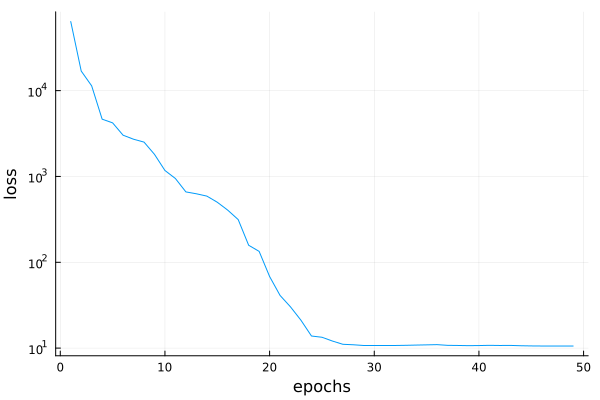

In [76]:
p = plot()
plot!(p, losses[findall(x->x!=0.0, losses)], ylabel="loss", xlabel="epochs", yaxis=:log, legend=false)
plot!(p, yticks=[1e1, 1e2, 1e3, 1e4, 1e5])
savefig("../results/opt_gas_flow_loss.png")
p

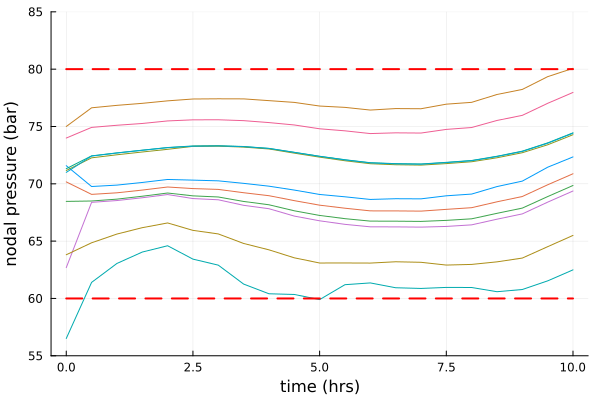

In [77]:
sol = solve(prob, SSPRK43(), p=best_params, dt=dt, saveat=saveat)
sol_arr = Array(sol)
p = plot()
for i in 1:length(net.vertices)
    plot!(p, sol.t/3600, pressure_from_density.(sol_arr[node_ρ_inds[i], :])/1e5, label="node $(i) pressure")
end
plot!(p, legend=false, xlabel="time (hrs)", ylabel="nodal pressure (bar)", ylims=(55,85))
plot!(p, sol.t/3600, [pmin/1e5 for i in sol.t], linestyle=:dash, linecolor=:red, linewidth=2, label=nothing)
plot!(p, sol.t/3600, [pmax/1e5 for i in sol.t], linestyle=:dash, linecolor=:red, linewidth=2, label="pressure limits")
savefig(p, "../results/opt_gas_flow_pressures.png")
p

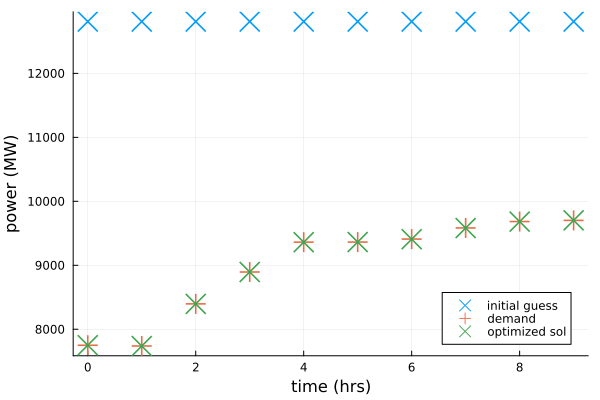

In [78]:
function generated_power(_params, ind)
    sum([kg_to_MW_per_s(-_params[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][ind], 
                generator_types[v_num]) 
            for v_num in 1:length(net.vertices)])
end
times = bc_tsteps[1:end-1]/3600;
p = plot()
scatter!(p, times, [generated_power(ps,i) for i in 1:length(bc_tsteps)-1], label="initial guess", markershape=:x, markersize=10, markerstrokewidth=2)
scatter!(p, times, demand, label="demand", markershape=:+, markersize=10, markerstrokewidth=2)
scatter!(p, times, [generated_power(best_params,i) for i in 1:length(bc_tsteps)-1], label="optimized sol", markershape=:x, markersize=10, markerstrokewidth=2)
plot!(p, ylabel="power (MW)", xlabel="time (hrs)", legend=:bottomright)
savefig(p, "../results/opt_gas_flow_demand.png")
p

# Solving Optimal Gas Flow Under Uncertainty

In [84]:
prob = remake(prob, p=randn(length(parameters(sys))));
function remake_prob(prob, i, repeat)
    @. prob.p += randn()*prob.p
    return prob
end
eprob = EnsembleProblem(prob, prob_func=remake_prob);
sols = solve(eprob, SSPRK43(), trajectories=10, dt=dt, adaptive=true, sensealg=InterpolatingAdjoint(), saveat=saveat, save_end=true);

In [86]:
prob = remake(prob, p=opt_sol.u) #just to convert ps to non MTK params
node_1_param_inds = 1:num_bc_per_node
node_8_param_inds = 7*num_bc_per_node+1:8*num_bc_per_node
function remake_prob(prob, i, repeat)
    prob.p .+= 0.05*randn()*[(i in node_1_param_inds || i in node_8_param_inds) ? 0.0 : prob.p[i] for i in 1:length(prob.p)]
    return prob
end
function ensemble_loss_fn(p, prob, trajs=10)
    prob = remake(prob, p=p)
    eprob = EnsembleProblem(prob, prob_func=remake_prob);
    sols = solve(eprob, SSPRK43(), EnsembleThreads(), trajectories=trajs, dt=dt, adaptive=true, sensealg=InterpolatingAdjoint(), saveat=saveat, save_end=true)
    loss = 0.0;
    for i in 1:trajs
        gas_cost = sum(relu.(-sols[i].prob.p))*bc_dt; #kg/s * s
        generated_power = [sum([kg_to_MW_per_s(-sols[i].prob.p[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][t_num], generator_types[v_num]) for v_num in 1:length(net.vertices)]) for t_num in 1:length(bc_tsteps)-1]
        demand_gap = sum(abs2, [demand[t_num] - generated_power[t_num] for t_num in 1:length(bc_tsteps)-1]/length(bc_tsteps))
        pressure_violation_penalty = sum([sum(pressure_violation_fn(pressure_from_density(sols[i][t_num][node_ρ_inds]))) for t_num in 2:length(saveat)])/length(saveat);
        loss += α * gas_cost + β * demand_gap + γ * pressure_violation_penalty;
    end
    return loss/trajs
end
@time ensemble_loss_fn(opt_sol.u, prob)
#@time gradient((p)->ensemble_loss_fn(p, prob), opt_sol.u)

  1.251942 seconds (3.38 M allocations: 208.907 MiB, 19.07% compilation time: 9% of which was recompilation)


530.8578175841271

In [87]:
itr_count = 1
max_iters = 50
best_params = zeros(length(prob.p));
losses = zeros(max_iters+1)
losses[1] = ensemble_loss_fn(opt_sol.u, prob)
best_params .= opt_sol.u;
function cb(state, loss_val)
    global itr_count += 1;
    losses[itr_count] = loss_val;
    if ((loss_val < minimum(losses[1:itr_count-1])))
        best_params .= state.u;
        println("best params updated!")
    end
    #if ((state.iter+1) % 50 == 0)
        println("iter = $(itr_count), loss = $(loss_val)");
    #end
    if (itr_count == max_iters-1)
        print("exit criteria hit")
        return true
    else
        return false
    end
end
opt_eprob = OptimizationProblem((p,u)->ensemble_loss_fn(p, prob, 5), opt_sol.u, nothing)
opt_esol = solve(opt_eprob, NelderMead(parameters = Optim.AdaptiveParameters(α = 1.0, β = 1.05, γ = 0.75, δ = 0.75)), callback=cb, maxiters=max_iters)


iter = 2, loss = 826.6818366914971
iter = 3, loss = 1673.7493309153808
iter = 4, loss = 695.9405131912099
iter = 5, loss = 1295.1523643681235
iter = 6, loss = 967.4269539612926
iter = 7, loss = 659.4224264050737
iter = 8, loss = 877.1888047511275
iter = 9, loss = 481.2303208027164
best params updated!
iter = 10, loss = 428.3159706425319
iter = 11, loss = 805.4125698116807
iter = 12, loss = 591.0741308987768
iter = 13, loss = 725.1690566443937
best params updated!
iter = 14, loss = 401.679067238195
iter = 15, loss = 758.3089652873805
best params updated!
iter = 16, loss = 129.13148827918184
iter = 17, loss = 861.7142285689818
iter = 18, loss = 898.9750535783791
iter = 19, loss = 1148.6809357397435
iter = 20, loss = 259.47217177096877
iter = 21, loss = 129.68118994723957
iter = 22, loss = 916.2780634823209
iter = 23, loss = 416.2012831559834
iter = 24, loss = 464.2439933926383
iter = 25, loss = 762.6290664201822
iter = 26, loss = 816.2483381992491
iter = 27, loss = 537.1413802455997
iter

retcode: Failure
u: 110-element Vector{Float64}:
   33.06962952554001
   27.362716301191565
   29.597331607594896
   32.14788132530111
   46.080166255560805
   40.99295015058707
   46.93972669772504
   54.87915316950338
   65.94151583054405
   82.49237614067064
 -106.63144729937343
 -106.83778153538024
 -113.58524008565398
    ⋮
  -18.270670182396724
  -19.887942128985404
   -8.58850826578883
   -6.809136122042872
  -13.584251518622203
   -9.888623140812234
  -10.24060860173394
  -10.923475129270184
  -11.427741321191311
  -11.27863440911966
  -11.052069913663603
  -11.406792289671937

In [89]:
prob = remake(prob, p=best_params);
eprob = EnsembleProblem(prob, prob_func=remake_prob);
sols = solve(eprob, SSPRK43(), trajectories=15, saveat=bc_tsteps);
prob = remake(prob, p=opt_sol.u);
eprob = EnsembleProblem(prob, prob_func=remake_prob);
og_sols = solve(eprob, SSPRK43(), trajectories=15, saveat=bc_tsteps);

[1.4709632111668204e-14; 0.38977946741009184; 0.7656432001563641; 1.1800626620935832; 1.6200503298797764; 2.083201541991379; 2.5496875211281713; 3.009205514677753; 3.465097941356067; 3.913173326398949; 4.34436004387491;;]
[2.2064448167502304e-14; 0.44777081547555936; 0.8337535801413685; 1.282490268249928; 1.7644308050401316; 2.2756810441341555; 2.767995227158572; 3.2467428780397714; 3.7381168921774015; 4.210362811676753; 4.662618745293864;;]
[0.0; 0.6218673890173467; 1.0545496062310822; 1.645779507226313; 2.3369527004696296; 2.8585934829631414; 3.178520339083196; 3.6914929340748257; 4.230672241068521; 4.86917184607722; 5.403647701153298;;]
[0.0; 0.2756357291149337; 0.6099432090597673; 0.968190884198007; 1.3476485880604672; 1.7528755212844493; 2.1688272645446065; 2.583864529029975; 2.9938254253136; 3.402393845106819; 3.8199420503667225;;]
[0.0; 0.2819658180800725; 0.6269725594786537; 0.9968729642675911; 1.39068133272361; 1.8084112037329185; 2.2382727581092703; 2.6673863049361057; 3.0931

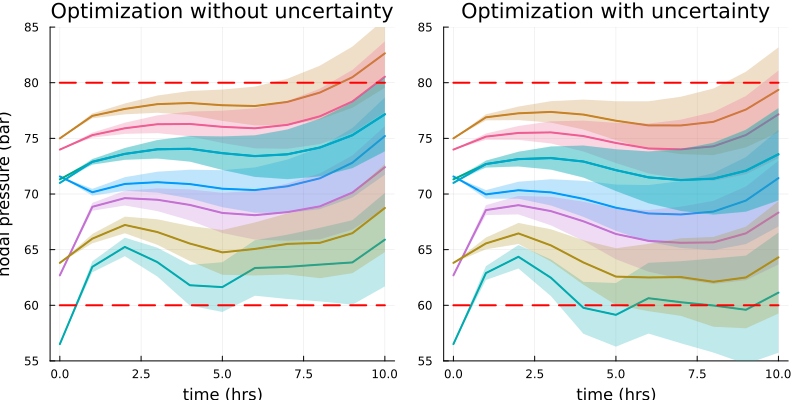

In [129]:
p = plot()
q = plot()
ts = sols[1].t/3600
for i in [1, 4, 6, 8, 7, 9, 5, 11]
    node_pressures = pressure_from_density.(hcat([[sols[e_num][t_num][node_ρ_inds[i]] for t_num in 1:length(sols[i].t)] for e_num in 1:length(sols)]...))/1e5
    m = mean(node_pressures, dims=2)
    σ = std(node_pressures, dims=2)
    println(σ)
    plot!(p, ts, m, ribbon=(σ), color=i, fillalpha=0.25, label=nothing)
    plot!(p, ts, m, color=i, linewidth=2, label="node $(i)")
        
    og_node_pressures = pressure_from_density.(hcat([[og_sols[e_num][t_num][node_ρ_inds[i]] for t_num in 1:length(og_sols[i].t)] for e_num in 1:length(og_sols)]...))/1e5
    m = mean(og_node_pressures, dims=2)
    σ = std(og_node_pressures, dims=2)
    plot!(q, ts, m, ribbon=(σ), color=i, fillalpha=0.25, label=nothing)
    plot!(q, ts, m, color=i, linewidth=2, label="node $(i)")
end
plot!(p, ts, [pmin/1e5 for i in ts], linestyle=:dash, linecolor=:red, linewidth=2, label=nothing)
plot!(p, ts, [pmax/1e5 for i in ts], linestyle=:dash, linecolor=:red, linewidth=2, label="pressure limits")
plot!(p, xlabel="time (hrs)", legend=false, title="Optimization with uncertainty", ylims=(55,85))

plot!(q, ts, [pmin/1e5 for i in ts], linestyle=:dash, linecolor=:red, linewidth=2, label=nothing)
plot!(q, ts, [pmax/1e5 for i in ts], linestyle=:dash, linecolor=:red, linewidth=2, label="pressure limits")
plot!(q, xlabel="time (hrs)", ylabel="nodal pressure (bar)", legend=false, title="Optimization without uncertainty", ylims=(55,85))

savefig(p, "../results/uncertain_ogf_pressures.png")
composite = plot(q, p, size=(800, 400))
savefig(composite, "../results/uncertain_ogf_pressure_comparison.png")
composite

# Multi-Fidelity Optimization

In [125]:
hyper_params = [#(dx, bc_dt)
    (4_000, 7200.0),
    (4_000, 3600.0),
    (2_000, 1800.0)]
models = Dict();
model_num = 1;
for (dx, bc_dt) in hyper_params
    T = 10 * 3600.0f0; # time [s]
    
    basepath = "../network_specs/israel_reduced/";
    
    net = parse_network_from_files(dx,
        basepath * "network_data/pipes.csv",
        basepath * "network_data/nodes.csv",
        basepath * "initial_conditions/pipe_ic.csv",
        basepath * "initial_conditions/node_ic.csv",
        basepath * "network_data/params_scen1.csv",
        density_from_pressure,
        pressure_from_density);

    tspan = (0.0f0, T);
    bc_dt = 3600.0;
    sys, prob = create_ode_problem!(net, dx, tspan, bc_dt=bc_dt);
    prob = remake(prob, p=zeros(length(parameters(sys))))
    push!(models, model_num=>Dict(:net=>net, :sys=>sys, :prob=>prob, :dx=>dx, :bc_dt=>bc_dt))

    # compile the models
    sol = solve(prob, SSPRK43(), sensealg=InterpolatingAdjoint())
    @time gradient((p)->solve(prob, SSPRK43(), p=p)[end][1], randn(length(parameters(sys)))) 
    model_num += 1
end
models

  1.128854 seconds (2.57 M allocations: 451.525 MiB, 5.25% gc time, 30.47% compilation time)
  0.862044 seconds (771.77 k allocations: 309.904 MiB, 33.70% gc time, 0.00% compilation time)
 66.644813 seconds (52.41 M allocations: 4.371 GiB, 1.56% gc time, 97.16% compilation time)


Dict{Any, Any} with 3 entries:
  2 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>4000, :prob=>ODEProblem{Vector{Fl…
  3 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>2000, :prob=>ODEProblem{Vector{Fl…
  1 => Dict{Symbol, Any}(:bc_dt=>3600.0, :dx=>4000, :prob=>ODEProblem{Vector{Fl…

In [126]:
function initialize_next_model_params_with_lower_fidelity_params!(hf_model, lf_model, lf_best_params)
    lf_bc_dt = lf_model[:bc_dt];
    hf_bc_dt = hf_model[:bc_dt];
    repeat_num = Int(hf_bc_dt/lf_bc_dt)

    @assert length(hf_model[:prob].p) == repeat_num*length(lf_model[:prob].p)
    @assert length(lf_best_params) == length(lf_model[:prob].p)
    hf_model[:prob] = remake(hf_model[:prob], p=vcat([[lf_model[:prob].p[i] for j in 1:repeat_num] for i in 1:length(lf_model[:prob].p)]...))
end
# initialize_next_model_params_with_lower_fidelity_params!(models[2], models[1], zeros(length(models[1][:prob].p)))
# models[2][:prob].p

initialize_next_model_params_with_lower_fidelity_params! (generic function with 1 method)

In [127]:
epochs_per_fidelity = 50;
total_epochs = model_num*epochs_per_fidelity;
losses = zeros(total_epochs)

#setup initial guess
num_bc_per_node = get_metadata(models[1][:net], :num_bc_tsteps);
ps = vcat([[node_max_fluxes[i] for j in 1:num_bc_per_node] for i in 1:length(net.vertices)]...)
ps[1:num_bc_per_node] .= 100.0;
models[1][:prob] = remake(models[1][:prob], p=ps)

#setup lowest fidelity optimization bounds
lf_lb = 1.1*ps;
lf_ub = zeros(length(lf_lb));
lf_lb[1:num_bc_per_node] .= 0.0;
lf_ub[1:num_bc_per_node] .= 225.0
lf_lb[7*num_bc_per_node+1:8*num_bc_per_node] .= 0.0;
lf_ub[7*num_bc_per_node+1:8*num_bc_per_node] .= 500;

objective(opt_vars, opt_params) = loss_fn(opt_vars, prob)
opt_fn = OptimizationFunction(objective, AutoZygote())
itr_count = 0
for i in 1:model_num
    if (i > 1) 
        #re-size optimization bounding box
        repeat_num = Int(models[i][:bc_dt]/models[1][:bc_dt])
        _lb = vcat([[lf_lb[i] for j in 1:num_bc_per_node] for i in 1:length(models[1][:net].vertices)]...)
        _ub = vcat([[lf_ub[i] for j in 1:num_bc_per_node] for i in 1:length(models[1][:net].vertices)]...)

        #initialize params to best sol from last level
        initialize_next_model_params_with_lower_fidelity_params!(models[i], models[i-1], models[i-1][:opt_sol].u)
    end
    prob,sys,net = models[i][:prob], models[i][:sys], models[i][:net];
    best_params = zeros(length(ps));


    function _cb(state, loss_val)
        global itr_count += 1;
        losses[itr_count] = loss_val;
        if ((itr_count > 1) && (loss_val < minimum(losses[1:itr_count-1])))
            best_params .= state.u;
        end
        #if ((state.iter+1) % 50 == 0)
            println("iter = $(itr_count), loss = $(loss_val)");
        #end
        if (itr_count == epochs_per_fidelity*i-1)
            println("exit criteria hit")
            return true
        else
            return false
        end
    end
    opt_prob = OptimizationProblem(opt_fn, prob.p, nothing, lb=lb, ub=ub)
    opt_sol = solve(opt_prob, LBFGS(), maxiters=epochs_per_fidelity, callback=_cb, x_tol=1e-2, g_tol=1e-3)
    push!(models[i], :opt_sol=>opt_sol)
end

iter = 1, loss = 87645.55747747199
iter = 2, loss = 58446.37768777525
iter = 3, loss = 38802.42477762398
iter = 4, loss = 21355.826425319327
iter = 5, loss = 21243.9696470069
iter = 6, loss = 20891.525196037655
iter = 7, loss = 18966.41562621721
iter = 8, loss = 16604.37922611108
iter = 9, loss = 15269.863812573078
iter = 10, loss = 12131.329004863192
iter = 11, loss = 12129.018808605098
iter = 12, loss = 12129.018808605098
iter = 13, loss = 7888.053975295334
iter = 14, loss = 7603.3697561314975
iter = 15, loss = 6825.355789159457
iter = 16, loss = 6825.239195237783
iter = 17, loss = 6825.239195237783
iter = 18, loss = 6825.073783599931
iter = 19, loss = 6825.073783599931
iter = 20, loss = 6824.965720056534
iter = 21, loss = 6824.965720056534
iter = 22, loss = 6824.965720056534
iter = 23, loss = 6824.965720056534
iter = 24, loss = 6824.873284520462
iter = 25, loss = 6824.873284520462
iter = 26, loss = 6824.8661404160175
iter = 27, loss = 6824.8661404160175
iter = 28, loss = 6824.642275

LoadError: KeyError: key 4 not found

In [ ]:
function generated_power(_params, ind)
    sum([kg_to_MW_per_s(-_params[(v_num-1)*num_bc_per_node+1:v_num*num_bc_per_node][ind], 
                generator_types[v_num]) 
            for v_num in 1:length(net.vertices)])
end
times = bc_tsteps[1:end-1]/3600;
p = plot()
scatter!(p, times, [generated_power(ps,i) for i in 1:length(bc_tsteps)-1], label="initial guess", markershape=:x, markersize=10, markerstrokewidth=2)
scatter!(p, times, demand, label="demand", markershape=:+, markersize=10, markerstrokewidth=2)
scatter!(p, times, [generated_power(best_params,i) for i in 1:length(bc_tsteps)-1], label="optimized sol", markershape=:x, markersize=10, markerstrokewidth=2)
plot!(p, ylabel="power (MW)", xlabel="time (hrs)", legend=:bottomright)
savefig(p, "../results/opt_gas_flow_demand.png")
p

# Benchmarks

In [31]:
@benchmark solve(prob, SSPRK43(), p=params, sensealg=InterpolatingAdjoint())

BenchmarkTools.Trial: 319 samples with 1 evaluation.
 Range (min … max):  11.740 ms … 25.580 ms  ┊ GC (min … max):  0.00% … 46.88%
 Time  (median):     13.288 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   15.693 ms ±  4.186 ms  ┊ GC (mean ± σ):  16.68% ± 19.00%

        ▅█                                                     
  ▃▃▂▃▃▅██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▃▃▂▂▃▃▃▂▃▃▃▃▂▃▂▂▂ ▂
  11.7 ms         Histogram: frequency by time        24.3 ms <

 Memory estimate: 33.60 MiB, allocs estimate: 20158.

In [32]:
@benchmark gradient(loss, params)

BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  204.606 ms … 224.408 ms  ┊ GC (min … max): 0.00% … 6.68%
 Time  (median):     217.938 ms               ┊ GC (median):    6.66%
 Time  (mean ± σ):   217.091 ms ±   4.836 ms  ┊ GC (mean ± σ):  5.77% ± 2.04%

  ▁▁                         ▁▁▁ █▁   ▁█  ▁█▁▁▁▁     █▁   █   ▁  
  ██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▁██▁▁▁██▁▁██████▁▁▁▁▁██▁▁▁█▁▁▁█ ▁
  205 ms           Histogram: frequency by time          224 ms <

 Memory estimate: 126.52 MiB, allocs estimate: 560278.

# General Plotting

In [ ]:
function plot_pressure_profile(; cm=cgrad(:roma, 10, categorical=true,
    scale=:exp), fps=15, vmax = 80, vmin = 40)

    x = [];
    y = [];
    for v in net.vertices
        push!(x, v.metadata[:longitude]);
        push!(y, v.metadata[:latitude]);
    end
    Δx = maximum(x) - minimum(x)
    Δy = maximum(y) - minimum(y)
    Δs = max(Δx,Δy)
    
    plot(legend = false, aspect_ratio=:equal, showaxis=:hide, xaxis=nothing,
        yaxis=nothing, grid=false)
    for (i, e) in enumerate(net.edges)
        from_node = e.metadata[:from_node]
        to_node = e.metadata[:to_node]
        from_x, to_x = x[from_node], x[to_node]
        from_y, to_y = y[from_node], y[to_node]
        rho = Meta.parse("sol[sys.edge_$(i)₊ρ][end]") |> eval
        p = net.metadata[:pressure_from_density](rho) / 1e5
        N = length(p)
        for n = 1:N
            dx = to_x - from_x
            dy = to_y - from_y
            x1 = dx * (n-1) / N + from_x
            x2 = dx * n / N + from_x
            y1 = dy * (n-1) / N + from_y
            y2 = dy * n / N + from_y
            plot!([x1; x2], [y1; y2], linewidth = 7.0,
                color=cgrad(cm)[max(min((p[n]-vmin)/(vmax-vmin), 1),0)] ,label="")
        end
    end

    p1 = scatter!(x, y,
        xlim = (minimum(x)-0.03*Δs, maximum(x)+0.03*Δs),
        ylim = (minimum(y)-0.03*Δs, maximum(y)+0.03*Δs),
        markersize = 10.0,
        markeralpha = 1.0,
        markercolor = :lightgreen,
        markerstrokewidth = 0.0)

    plot!(p1, annotations = (x, y, Plots.text.(1:num_vertices(net), :center)))

    h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=(vmin,vmax),
        xlims=(1,1.1), label="", c=cm, colorbar_title="Pressure (bar)",
        framestyle=:none, margin=0.0Plots.mm)

    l = @layout [a{0.8w} a{0.1w}]
    p = plot(p1, h2, layout = l)
end